## Data Loading

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv


In [2]:
df_tweets = pd.read_csv("/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv")
df_tweets[:10]

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
5,"@Raja5aab @Quickieleaks Yes, the test of god i...",not_cyberbullying
6,Itu sekolah ya bukan tempat bully! Ga jauh kay...,not_cyberbullying
7,Karma. I hope it bites Kat on the butt. She is...,not_cyberbullying
8,@stockputout everything but mostly my priest,not_cyberbullying
9,Rebecca Black Drops Out of School Due to Bully...,not_cyberbullying


In [3]:
df_tweets.groupby(by="cyberbullying_type").count()

,tweet_text
cyberbullying_type,
age,7992
ethnicity,7961
gender,7973
not_cyberbullying,7945
other_cyberbullying,7823
religion,7998


## Data Cleaning

### Checking Missing Values

In [4]:
def check_missing_values(col):
    counter = 0
    for element in col:
        if element == True:
            counter += 1
    return counter

In [5]:
df_tweets.isnull().apply(lambda x: check_missing_values(x))

tweet_text            0
cyberbullying_type    0
dtype: int64

### Checking Duplicates

In [6]:
def check_duplicated_values(x):
    return x.duplicated().sum()

In [7]:
df_tweets.apply(lambda x: check_duplicated_values(x))

tweet_text             1675
cyberbullying_type    47686
dtype: int64

In [8]:
df_tweets.loc[:,["tweet_text"]].duplicated().sum()

1675

In [9]:
df_tweets = df_tweets.drop_duplicates(subset=['tweet_text'])

In [10]:
df_tweets.apply(lambda x: check_duplicated_values(x))

tweet_text                0
cyberbullying_type    46011
dtype: int64

In [11]:
df_tweets.groupby(by="cyberbullying_type").count()

,tweet_text
cyberbullying_type,
age,7992
ethnicity,7952
gender,7898
not_cyberbullying,7937
other_cyberbullying,6243
religion,7995


## Data Transformation

### Balancing the Dataset

In [12]:
df_tweets = df_tweets.groupby(by="cyberbullying_type").sample(n=1000, random_state=1)
print("Length: "+ str(len(df_tweets)))
df_tweets[:5]

Length: 6000


,tweet_text,cyberbullying_type
34044,She looks so beautiful and she’s has a very ki...,age
38234,My old high school bully just tried to menace ...,age
36306,From my experience PE teachers are bullies. I ...,age
36793,ew why is gun/poop girl trending literally go ...,age
37263,Lara Spencer is so unprofessional. She bullied...,age


In [13]:
df_tweets.groupby(by="cyberbullying_type").count()

,tweet_text
cyberbullying_type,
age,1000
ethnicity,1000
gender,1000
not_cyberbullying,1000
other_cyberbullying,1000
religion,1000


### Splitting Test and Train/Validation sets
I will create a test set. A set not touched to evaluation later on the model performance.
Also, I will create a valid-train set. It to be separated later on.

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
df_x_tv, df_x_test, df_y_tv, df_y_test = train_test_split(df_tweets['tweet_text'], df_tweets['cyberbullying_type'], test_size=0.20,random_state=42)

## Data Preprocessing

### Tokenization

In [16]:
import spacy

nlp = spacy.load('en_core_web_sm')

# to be used in the without stopwords version
all_stopwords = nlp.Defaults.stop_words 

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']

caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']

  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']

caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10t

In [17]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [18]:
# Remove URLs
def remove_urls(text):
    text = re.sub(r"\S*https?:\S*", "", text, flags=re.MULTILINE)
    return text

In [19]:
import re

def tokenize_without_stopwords(cell):
    nlp_text = nlp(cell)
    tokens = [remove_urls(token.text).lower() for token in nlp_text if token.text.isalnum() and not token.text in all_stopwords]
    return tokens

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

term_doc_m = CountVectorizer(tokenizer=tokenize_without_stopwords,max_df=0.8,min_df=0.01,max_features=4000)

In [21]:
term_doc_m.fit(df_x_tv)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

  warnings.warn(


CountVectorizer(max_df=0.8, max_features=4000, min_df=0.01,
                tokenizer=<function tokenize_without_stopwords at 0x7db3aa796b90>)

In [22]:
len(term_doc_m.get_feature_names_out())

140

In [23]:
df_x = term_doc_m.transform(df_x_tv)
df_x.shape

(4800, 140)

In [24]:
df_x_test = term_doc_m.transform(df_x_test)
df_x_test.shape

(1200, 140)

### Hot Encoding

In [25]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(df_tweets['cyberbullying_type'])
print('Labels: ', label_encoder.classes_)


def label_encode(labels):
    encoding = label_encoder.transform(labels)
    return tf.keras.utils.to_categorical(encoding,len(label_encoder.classes_))


def label_decode(labels):
    decoding = np.argmax(labels, axis=1)
    return label_encoder.inverse_transform(decoding)

Labels:  ['age' 'ethnicity' 'gender' 'not_cyberbullying' 'other_cyberbullying'

 'religion']


In [26]:
label_encode(['age', 'ethnicity' ,'gender', 'not_cyberbullying' ,'other_cyberbullying','religion'])

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [27]:
df_y = label_encode(df_y_tv)
df_y[:5]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [28]:
df_y_test = label_encode(df_y_test)
df_y_test[:5]

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

### spliting the dataset in the training and validation sets
We already have the test set

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
df_x_train, df_x_valid, df_y_train, df_y_valid = train_test_split(df_x, df_y, test_size=0.30,random_state=42)

### Checking Balance

In [31]:
counter = {}

labels = ['age', 'ethnicity' ,'gender', 'not_cyberbullying' ,'other_cyberbullying','religion']
comparater = label_encode(labels)

#init
def initCounter():
    for i in label_encoder.classes_:
        counter[i] = 0

def countCategories(x):
    for idx, y in enumerate(comparater):
        if (x == y).all():
            counter[labels[idx]] = counter[labels[idx]] + 1
            return          

In [32]:
initCounter()
for i in df_y_train:
    countCategories(i)
    
counter

{'age': 552,
 'ethnicity': 525,
 'gender': 575,
 'not_cyberbullying': 556,
 'other_cyberbullying': 590,
 'religion': 562}

In [33]:
initCounter()
for i in df_y_valid:
    countCategories(i)
    
counter   

{'age': 233,
 'ethnicity': 253,
 'gender': 249,
 'not_cyberbullying': 240,
 'other_cyberbullying': 221,
 'religion': 244}

In [34]:
initCounter()
for i in df_y_test:
    countCategories(i)
    
counter  

{'age': 215,
 'ethnicity': 222,
 'gender': 176,
 'not_cyberbullying': 204,
 'other_cyberbullying': 189,
 'religion': 194}

## Modeling

In [35]:
regularizer = tf.keras.regularizers.l1_l2(0, 0.001)
classes_len = len(label_encoder.classes_)

### Creating Models

In [36]:
input_shape = len(term_doc_m.get_feature_names_out())
input_shape

140

In [37]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_shape,)),
    tf.keras.layers.Embedding(input_shape, 6),
#     tf.keras.layers.Conv1D(528, 15, activation='relu'),
#     tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Flatten(), # I flatten the embedding in order to use the dense layers, I dont use the previous 2 commented layers because they reduced the result to only one class instead of 6
    tf.keras.layers.Dense(500, kernel_regularizer=regularizer, activation=tf.keras.activations.relu),
    tf.keras.layers.Dropout(rate=0.4),
    tf.keras.layers.Dense(200, kernel_regularizer=regularizer, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(200, kernel_regularizer=regularizer, activation=tf.keras.activations.relu),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(50, kernel_regularizer=regularizer, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(6, kernel_regularizer=regularizer),
    tf.keras.layers.Softmax()
])

model.summary()
model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 embedding (Embedding)       (None, 140, 6)            840       

                                                                 

 flatten (Flatten)           (None, 840)               0         

                                                                 

 dense (Dense)               (None, 500)               420500    

                                                                 

 dropout (Dropout)           (None, 500)               0         

                                                                 

 dense_1 (Dense)             (None, 200)               100200    

                                                                 

 dense_2 (Dense)             (None, 200)               40200     

                                                                 

 dropout_1 (Dropout)         (None, 200)

In [38]:
epoch = 10
batch = 100

In [39]:
history = model.fit(df_x_train, df_y_train, epochs=epoch, batch_size=batch, validation_data=(df_x_valid,df_y_valid))

Epoch 1/10

34/34 [==============================] - 3s 29ms/step - loss: 2.5387 - accuracy: 0.2271 - val_loss: 2.1132 - val_accuracy: 0.3785

Epoch 2/10

34/34 [==============================] - 1s 17ms/step - loss: 1.5383 - accuracy: 0.5354 - val_loss: 1.0882 - val_accuracy: 0.6903

Epoch 3/10

34/34 [==============================] - 1s 20ms/step - loss: 0.9941 - accuracy: 0.7039 - val_loss: 0.8790 - val_accuracy: 0.7312

Epoch 4/10

34/34 [==============================] - 1s 19ms/step - loss: 0.8458 - accuracy: 0.7426 - val_loss: 0.7916 - val_accuracy: 0.7750

Epoch 5/10

34/34 [==============================] - 1s 17ms/step - loss: 0.7816 - accuracy: 0.7690 - val_loss: 0.7651 - val_accuracy: 0.7785

Epoch 6/10

34/34 [==============================] - 1s 18ms/step - loss: 0.7611 - accuracy: 0.7830 - val_loss: 0.7471 - val_accuracy: 0.7792

Epoch 7/10

34/34 [==============================] - 1s 19ms/step - loss: 0.7235 - accuracy: 0.7878 - val_loss: 0.7261 - val_accuracy: 0.7993


### Visualization Generalization Results

In [40]:
import matplotlib.pyplot as plt

def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_' + metric])
        ax[idx].legend([metric, 'val_' + metric])

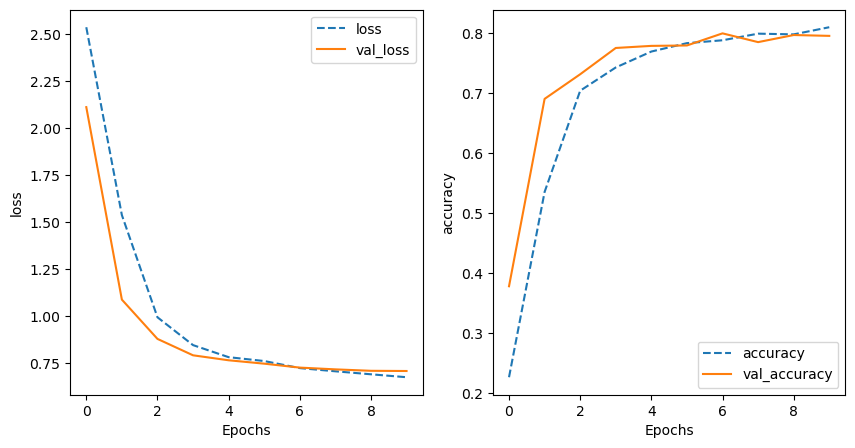

In [41]:
training_plot(['loss', 'accuracy'], history)

### Predictions

In [42]:
## predict
df_y_test_pred = model.predict(df_x_test)

38/38 [==============================] - 0s 4ms/step


### Visualization Predictions

In [43]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [44]:
# Funtion for visualizing confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    classes.sort()
    tick_marks = np.arange(len(classes))    
    plt.figure(figsize=(4, 4),dpi=115)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [45]:
pred_result = label_decode(df_y_test_pred)
true_result = label_decode(df_y_test)
print(classification_report(y_true=true_result, y_pred=pred_result))

                     precision    recall  f1-score   support



                age       0.99      0.94      0.96       215

          ethnicity       0.99      0.97      0.98       222

             gender       0.94      0.67      0.78       176

  not_cyberbullying       0.66      0.32      0.43       204

other_cyberbullying       0.46      0.90      0.61       189

           religion       0.97      0.92      0.95       194



           accuracy                           0.79      1200

          macro avg       0.84      0.79      0.79      1200

       weighted avg       0.84      0.79      0.79      1200




Confusion matrix, without normalization


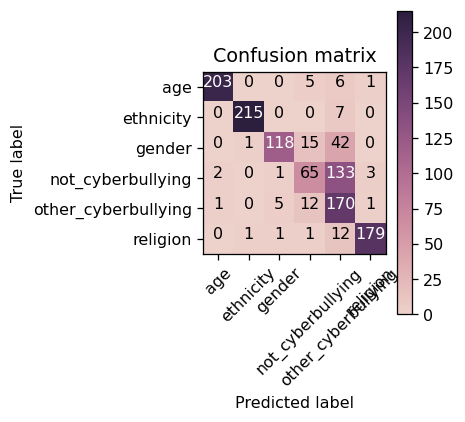

In [46]:
# plot confusion matrix
cm = confusion_matrix(y_true=true_result, y_pred=pred_result) 
plot_confusion_matrix(cm, classes=labels, title='Confusion matrix')

## Final Thoughts
I got better results by using an embedding layer. We have less overfitting. The real challenge in the model is separate: not cyberbullying vs other cyberbullying. Because the category other_cyberbullying doesn't belong to some specific category. Its scope is bigger than the other categories, making it difficult to difference its key patterns. 

It is important to note, that the dimensionality used in the input differs. Furthermore, we use a minimun frequency value to avoid terms that ocurred less than 1%, or terms that ocurred over 80% of the dataset.